In [1]:
import sys

import blosc
import numpy as np
import matplotlib.pyplot as plt
from pandas import ewma
from tqdm import tqdm_notebook as tqn
from IPython.display import clear_output
%matplotlib inline
sys.path.append('..')
import utils
from network import FourHeadedInception
from batch_generator import TwoMnistBatch
from dataset import Dataset, B, V, Pipeline
from dataset.opensets import MNIST

In [2]:
dset = MNIST(batch_class=TwoMnistBatch)

ExtractingExtracting  /tmp/train-images-idx3-ubyte.gzExtracting/tmp/train-labels-idx1-ubyte.gz
 Extracting
 /tmp/t10k-images-idx3-ubyte.gz
/tmp/t10k-labels-idx1-ubyte.gz


In [3]:
ppl = (Pipeline()
       .resize(shape=(128, 128))
       .normalize_images()
       .gluing_of_images()
       .colorize_images(colors=[[0., 0., 1.], [0., 1., 0.]]))

1 0 5 6


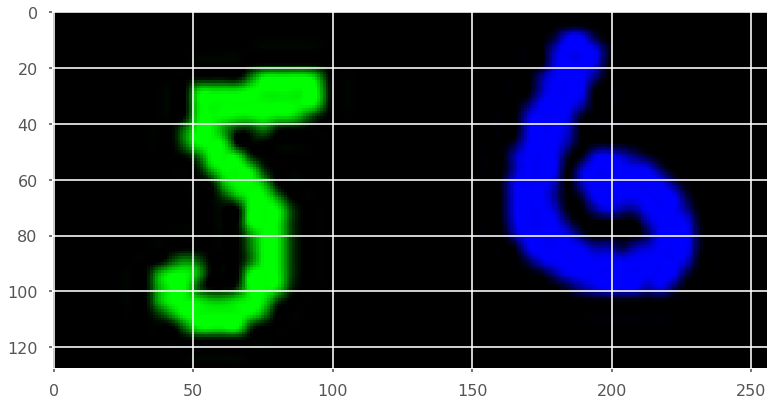

In [4]:
a = (ppl<<dset.train).next_batch(100)
plt.imshow(a.images[0].reshape(128, -1, 3))
print(a.first_color[0], a.second_color[0], a.first_number[0], a.second_number[0])

In [5]:
inputs_config = {'images': {'shape':(128, 256, 3)},
                 'labels':{'shape':(2)},
                 'fir_col': {'classes':(2), 'transform': 'ohe', 'name':'first_color'},
                 'sec_col': {'classes':(2), 'transform': 'ohe', 'name':'second_color'},
                 'first': {'classes':(10), 'transform': 'ohe', 'name':'first_number'},
                 'second': {'classes':(10), 'transform': 'ohe', 'name':'second_number'}}

config = {'inputs':inputs_config,
          'optimizer': 'Adam',
          'loss': None,
          'input_block/inputs': 'images',
          'head/color_importance': 1.}

four_headed_dict = {'images': B('images'),
                    'labels': B('labels'),
                    'fir_col': B('first_color'),
                    'sec_col': B('second_color'),
                    'first': B('first_number'),
                    'second': B('second_number')}

In [6]:
def create_ppl(config):
    four_headed_ppl = ((ppl<<dset.train)
                        .init_variable('loss_c1', init_on_each_run=list)
                        .init_variable('loss_c2', init_on_each_run=list)
                        .init_variable('loss_n1', init_on_each_run=list)
                        .init_variable('loss_n2', init_on_each_run=list)
                        .init_model('dynamic',
                                    FourHeadedInception,
                                    'fourinception',
                                    config=config)
                       .train_model('fourinception',
                                    fetches=['FourHeadedInception/loss_c1:0',
                                             'FourHeadedInception/loss_c2:0',
                                             'FourHeadedInception/loss_n1:0',
                                             'FourHeadedInception/loss_n2:0'],
                                    feed_dict=four_headed_dict,
                                    save_to=[V('loss_c1'),
                                             V('loss_c2'),
                                             V('loss_n1'),
                                             V('loss_n2')], 
                                    mode='a'))
    return four_headed_ppl

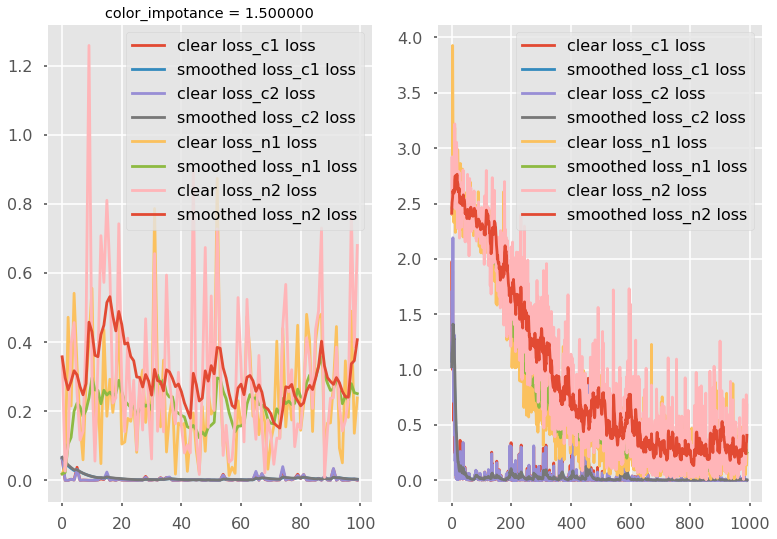

In [7]:
names = ['loss_c1', 'loss_c2', 'loss_n1', 'loss_n2']
global_loss = []
importance = [0.5, 0.8, 1.5]
for imp in tqn(importance):
    config['head/color_importance'] = imp
    new_ppl = create_ppl(config)
    for i in tqn(range(1000)):
        new_ppl.next_batch(23, n_epochs=None, shuffle=True)
        if i%10==0:
            clear_output(True)
            losses = [new_ppl.get_variable(name) for name in names]
            utils.four_losses_draw(losses, names, 'color_impotance = %f'%imp)
    global_loss.append(losses)
    save_model.append(new_ppl)

../utils.py:250: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  ax[0].plot(ewma(np.array(loss[-100:]),span=10,adjust=False), label='smoothed %s loss'%name)
../utils.py:252: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  ax[1].plot(ewma(np.array(loss),span=10,adjust=False), label='smoothed %s loss'%name)


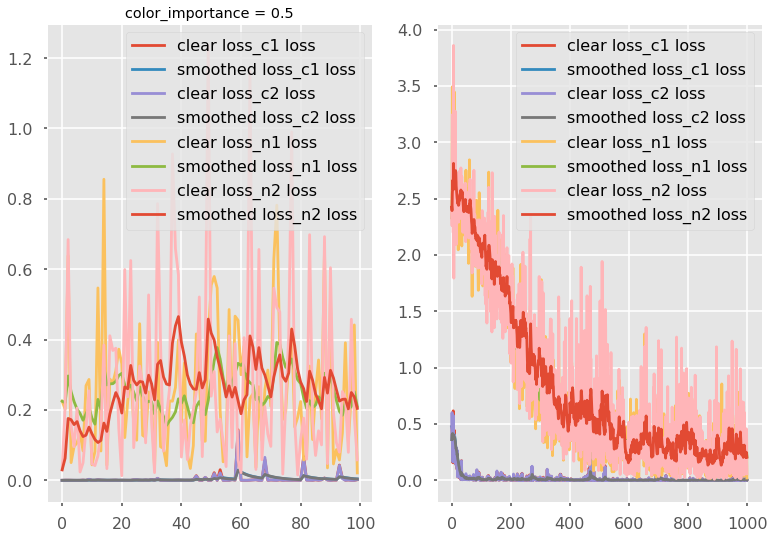

In [10]:
utils.four_losses_draw(global_loss[0], names, 'color_importance = 0.5')

../utils.py:250: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  ax[0].plot(ewma(np.array(loss[-100:]),span=10,adjust=False), label='smoothed %s loss'%name)
../utils.py:252: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  ax[1].plot(ewma(np.array(loss),span=10,adjust=False), label='smoothed %s loss'%name)


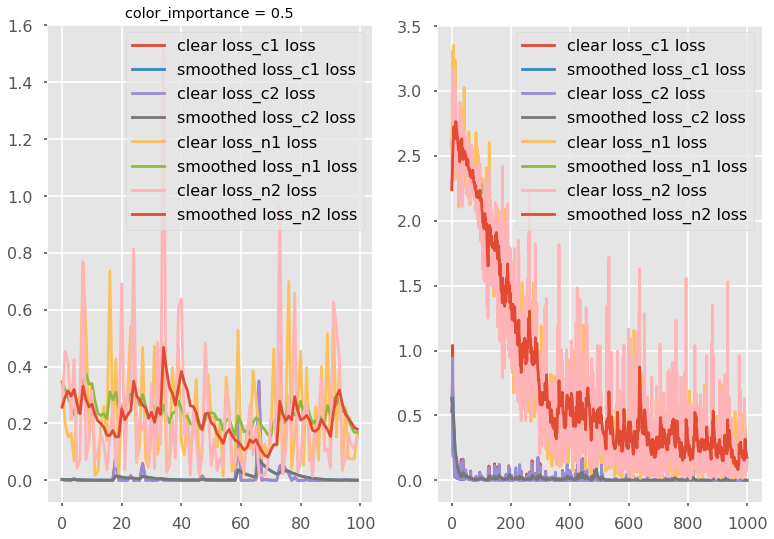

In [11]:
utils.four_losses_draw(global_loss[1], names, 'color_importance = 0.8')

../utils.py:250: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  ax[0].plot(ewma(np.array(loss[-100:]),span=10,adjust=False), label='smoothed %s loss'%name)
../utils.py:252: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  ax[1].plot(ewma(np.array(loss),span=10,adjust=False), label='smoothed %s loss'%name)


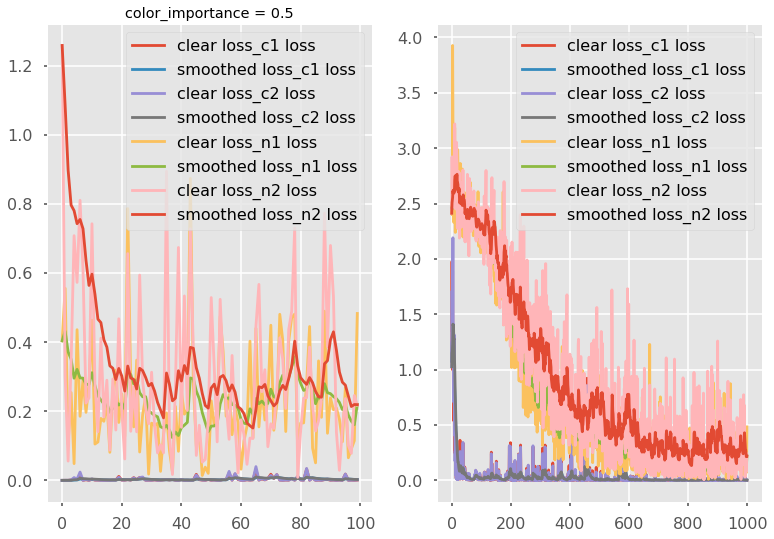

In [12]:
utils.four_losses_draw(global_loss[2], names, 'color_importance = 0.8')

In [13]:
four_headed_test = ((ppl<<dset.test)
                    .init_variable('first_color', init_on_each_run=list)
                    .init_variable('second_color', init_on_each_run=list)
                    .init_variable('first_num', init_on_each_run=list)
                    .init_variable('second_num', init_on_each_run=list)
                    .import_model('fourinception', new_ppl)
                    .predict_model('fourinception', 
                                   fetches=['FourHeadedInception/first_color:0', 
                                            'FourHeadedInception/second_color:0',
                                            'FourHeadedInception/first_number:0',
                                            'FourHeadedInception/second_number:0'],
                         feed_dict=four_headed_dict,
                         save_to=[V('first_color'),
                                  V('second_color'), 
                                  V('first_num'), 
                                  V('second_num')], mode='a'))

1 0 9 7


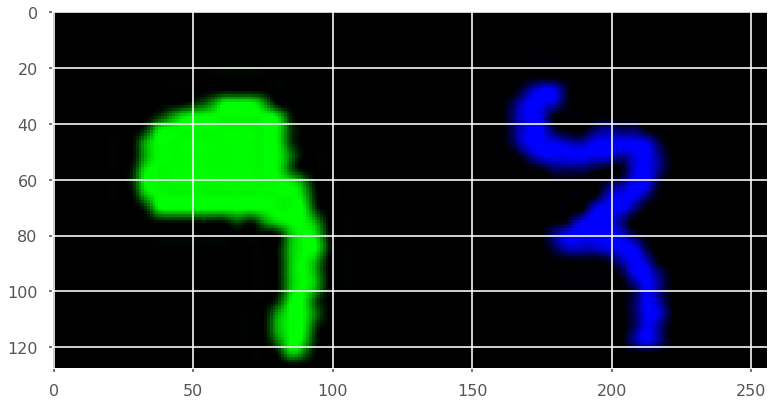

In [15]:
batch = four_headed_test.next_batch(500)
plt.imshow(batch.images[-1])
first_color = four_headed_test.get_variable('first_color')
second_color = four_headed_test.get_variable('second_color')
first_num = four_headed_test.get_variable('first_num')
second_num = four_headed_test.get_variable('second_num')
print(np.argmax(first_color[-1][-1]), np.argmax(second_color[-1][-1]), \
      np.argmax(first_num[-1][-1]), np.argmax(second_num[-1][-1]))